In [1]:
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
import numpy as np
import math
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
a = unpickle('cifar-10-batches-py/data_batch_1')
print(a.keys()) # we only need labels and data

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [4]:
print(np.array(a[b'labels']).shape)
print(a[b'data'].shape) # every photo's shape is [32,32,3]

(10000,)
(10000, 3072)


In [5]:
# data preprocessing
file_name = 'cifar-10-batches-py/'
x_train = np.zeros((50000,32,32,3))
y_train = np.zeros(50000)
x_test = np.zeros((10000,32,32,3))
y_test = np.zeros(10000)
for i in range(5):
    batch_dict = unpickle(file_name+'data_batch_'+str(i+1))
    for j in range(10000):
        data = np.array(batch_dict[b'data'][j],dtype = np.float32).reshape(3,32,32).transpose(1,2,0)
        x_train[i*10000+j] = data
        
    batch_label = np.array(batch_dict[b'labels'])
    y_train[i*10000:(i+1)*10000] = batch_label

test_dict = unpickle(file_name+'test_batch')
for j in range(10000):
    data = np.array(test_dict[b'data'][j],dtype = np.float32).reshape(3,32,32).transpose(1,2,0)
    x_test[j] = data

y_test = np.array(test_dict[b'labels'])

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

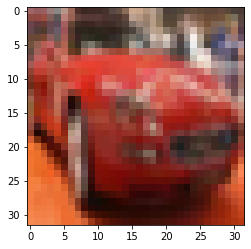

In [6]:
plt.imshow(x_train[5].astype(np.int32))

In [7]:

# standardization
train_mean = np.mean(x_train)
train_std = np.std(x_train)
x_train = (x_train - train_mean)/train_std
x_test = (x_test - train_mean)/train_std
"""
x_train = x_train/255
x_test = x_test/255
"""

'\nx_train = x_train/255\nx_test = x_test/255\n'

In [8]:
# split trainind data to training and validation
num_val = 5000
indice = np.arange(x_train.shape[0])
np.random.shuffle(indice)
x_train = x_train[indice]
y_train = y_train[indice]
partial_train_x = x_train[:-num_val]
x_val = x_train[-num_val:]
partial_train_y = y_train[:-num_val]
y_val = y_train[-num_val:]
print(partial_train_x.shape,partial_train_y.shape)
print(x_val.shape,y_val.shape)

(45000, 32, 32, 3) (45000, 10)
(5000, 32, 32, 3) (5000, 10)


In [9]:
def build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), padding = "same", activation='relu',input_shape=(32, 32, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), padding = "same", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv2D(64, (3, 3), padding = "same", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), padding = "same", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv2D(128, (3, 3), padding = "same", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), padding = "same", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    #model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(10,activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=1e-3),
                  metrics=['acc'])
    return model

In [10]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

In [11]:
# start training
history = model.fit(
      partial_train_x,partial_train_y,
      epochs=30,
      batch_size=32,
      validation_data=(x_val,y_val),
      #verbose = 0
      )

Epoch 1/30
1407/1407 [==============================] - 14s 7ms/step - loss: 1.6792 - acc: 0.4417 - val_loss: 1.1315 - val_acc: 0.6078
Epoch 2/30
1407/1407 [==============================] - 9s 7ms/step - loss: 1.0894 - acc: 0.6120 - val_loss: 0.8782 - val_acc: 0.6916
Epoch 3/30
1407/1407 [==============================] - 9s 7ms/step - loss: 0.9288 - acc: 0.6742 - val_loss: 0.7119 - val_acc: 0.7540
Epoch 4/30
1407/1407 [==============================] - 10s 7ms/step - loss: 0.8226 - acc: 0.7118 - val_loss: 0.6762 - val_acc: 0.7628
Epoch 5/30
1407/1407 [==============================] - 9s 7ms/step - loss: 0.7415 - acc: 0.7461 - val_loss: 0.6522 - val_acc: 0.7720
Epoch 6/30
1407/1407 [==============================] - 9s 7ms/step - loss: 0.6764 - acc: 0.7678 - val_loss: 0.5914 - val_acc: 0.7954
Epoch 7/30
1407/1407 [==============================] - 9s 7ms/step - loss: 0.6295 - acc: 0.7843 - val_loss: 0.5361 - val_acc: 0.8130
Epoch 8/30
1407/1407 [==============================] - 9s 7

In [12]:
# start testing
performance = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", performance[0])
print("Test accuracy:", performance[1])

Test loss: 0.44269508123397827
Test accuracy: 0.8596000075340271


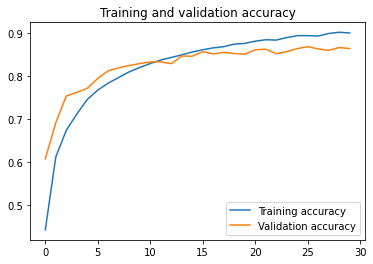

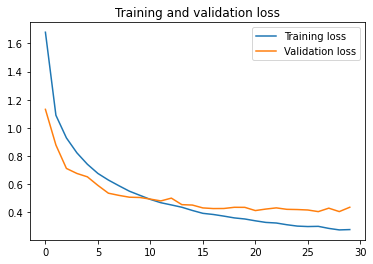

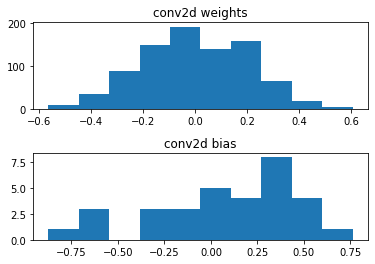

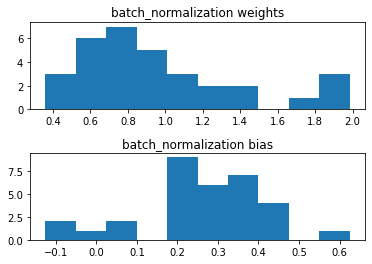

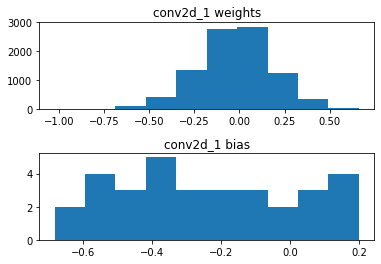

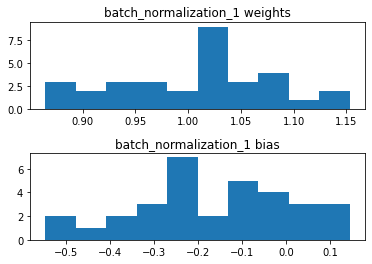

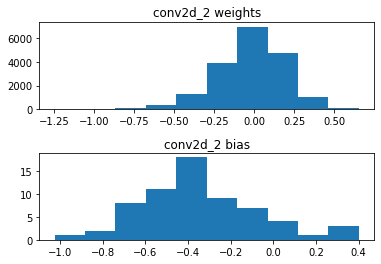

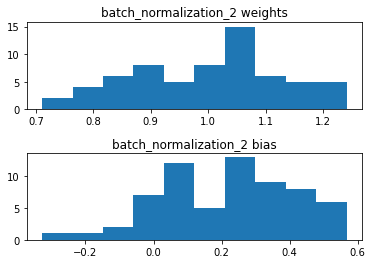

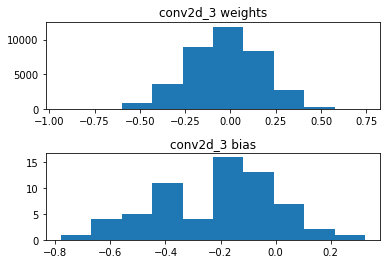

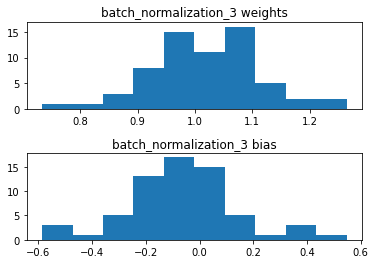

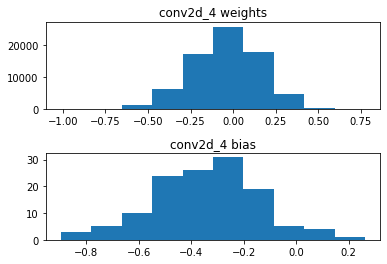

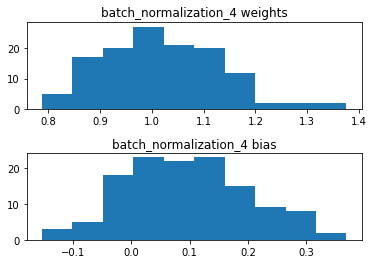

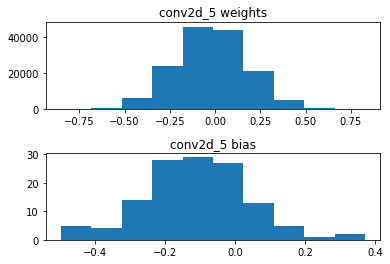

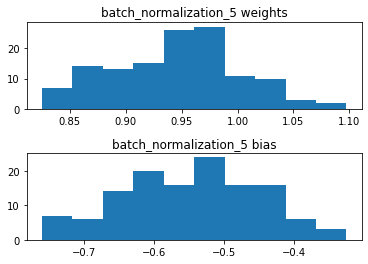

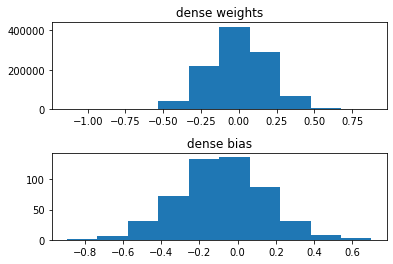

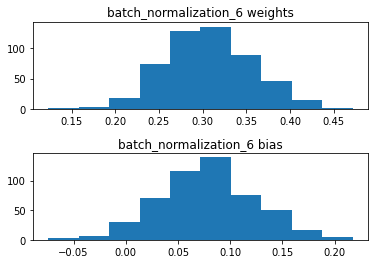

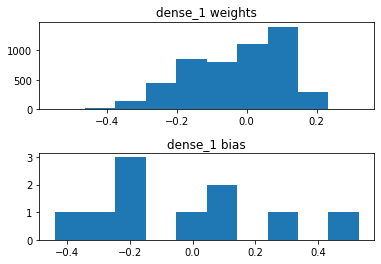

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

def plot_training(train_loss,val_loss,title,metrix):
    epochs = range(len(train_loss))
    plt.plot(epochs, train_loss, '-', label='Training '+metrix)
    plt.plot(epochs, val_loss, '-', label='Validation '+metrix)
    plt.title(title)
    plt.legend()
    plt.show()

def plot_weight(model):
    for layer in model.layers:
        plt.subplots_adjust(hspace=0.5)
        if len(layer.get_weights()) == 0:
            continue
        plt.subplot(211)
        plt.hist(layer.get_weights()[0].flatten())
        plt.title(layer.name+' weights')

        plt.subplot(212)
        plt.hist(layer.get_weights()[1].flatten())
        plt.title(layer.name+' bias')
        plt.show()
        plt.close()
        
plot_training(acc,val_acc,'Training and validation accuracy', 'accuracy')
plot_training(loss,val_loss,'Training and validation loss', 'loss')
plot_weight(model)

In [14]:
#data augmentation
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    #rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    #shear_range=0.1,
    #zoom_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow(x_train,y_train,batch_size=32)

In [15]:
model = build_model()
history = model.fit(
      #x_train,y_train,
      #batch_size=32,
      train_generator,
      steps_per_epoch=50000//32,
      validation_data=(x_test, y_test),
      epochs=100,
      #verbose = 0
      )

Epoch 1/100
1562/1562 [==============================] - 14s 9ms/step - loss: 1.7820 - acc: 0.3998 - val_loss: 1.3724 - val_acc: 0.5349
Epoch 2/100
1562/1562 [==============================] - 13s 9ms/step - loss: 1.2723 - acc: 0.5454 - val_loss: 0.9960 - val_acc: 0.6474
Epoch 3/100
1562/1562 [==============================] - 14s 9ms/step - loss: 1.0699 - acc: 0.6224 - val_loss: 0.9878 - val_acc: 0.6558
Epoch 4/100
1562/1562 [==============================] - 13s 8ms/step - loss: 0.9583 - acc: 0.6624 - val_loss: 0.7692 - val_acc: 0.7305
Epoch 5/100
1562/1562 [==============================] - 14s 9ms/step - loss: 0.8784 - acc: 0.6953 - val_loss: 0.6741 - val_acc: 0.7685
Epoch 6/100
1562/1562 [==============================] - 14s 9ms/step - loss: 0.8161 - acc: 0.7183 - val_loss: 0.6959 - val_acc: 0.7634
Epoch 7/100
1562/1562 [==============================] - 14s 9ms/step - loss: 0.7842 - acc: 0.7297 - val_loss: 0.7003 - val_acc: 0.7648
Epoch 8/100
1562/1562 [=========================

In [16]:
# start testing
performance = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", performance[0])
print("Test accuracy:", performance[1])

Test loss: 0.32648712396621704
Test accuracy: 0.8924000263214111


In [17]:
model.save('cifar_data_aug.h5')